In [36]:
from functools import partial

import numpy as np
import pandas as pd
import os
import random
import time

import tensorflow as tf, re, math
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model, Sequential
from tensorflow.keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import gc
import uproot

### Getting the data

In [9]:
def get_df(root_file_name, filter_name):
    events = uproot.open(root_file_name, filter_name=filter_name)["tree"]
    df = events.arrays(library="pd")
    return df

features = []
# variables: general
features += ['FatJet_pt', 'FatJet_eta', 'FatJet_phi', 'FatJet_DDX_jetNSecondaryVertices', \
             'FatJet_DDX_jetNTracks', 'FatJet_DDX_z_ratio', 'FatJet_Proba', 'FatJet_area', \
             'FatJet_jetId', 'FatJet_lsf3', 'FatJet_rawFactor', 'FatJet_n2b1', 'FatJet_n3b1', \
            ]

# variables: tau1
features += ['FatJet_tau1', 'FatJet_DDX_tau1_flightDistance2dSig', 'FatJet_DDX_tau1_trackEtaRel_0', \
             'FatJet_DDX_tau1_trackEtaRel_1', 'FatJet_DDX_tau1_trackEtaRel_2', 'FatJet_DDX_tau1_trackSip3dSig_0', \
             'FatJet_DDX_tau1_trackSip3dSig_1', 'FatJet_DDX_tau1_vertexDeltaR', 'FatJet_DDX_tau1_vertexEnergyRatio', \
            ]

# variables: tau2
features += ['FatJet_tau2', 'FatJet_DDX_tau2_flightDistance2dSig', 'FatJet_DDX_tau2_trackEtaRel_0', \
             'FatJet_DDX_tau2_trackEtaRel_1', 'FatJet_DDX_tau2_trackEtaRel_3', 'FatJet_DDX_tau2_trackSip3dSig_0', \
             'FatJet_DDX_tau2_trackSip3dSig_1', 'FatJet_DDX_tau2_vertexEnergyRatio', \
            ]

# variables: tau3 and tau4
features += ['FatJet_tau3', 'FatJet_tau4',]

# variables: track
features += ['FatJet_DDX_trackSip2dSigAboveBottom_0', 'FatJet_DDX_trackSip2dSigAboveBottom_1', \
             'FatJet_DDX_trackSip2dSigAboveCharm', 'FatJet_DDX_trackSip3dSig_0', \
             'FatJet_DDX_trackSip3dSig_1', 'FatJet_DDX_trackSip3dSig_2', 'FatJet_DDX_trackSip3dSig_3', \
            ]

# variables: subjet 1
features += ['FatJet_subjet1_pt', 'FatJet_subjet1_eta', 'FatJet_subjet1_phi', \
             'FatJet_subjet1_Proba', 'FatJet_subjet1_tau1', 'FatJet_subjet1_tau2', \
             'FatJet_subjet1_tau3', 'FatJet_subjet1_tau4', 'FatJet_subjet1_n2b1', 'FatJet_subjet1_n3b1', \
            ]

# variables: subjet 2
features += ['FatJet_subjet2_pt', 'FatJet_subjet2_eta', 'FatJet_subjet2_phi', \
             'FatJet_subjet2_Proba', 'FatJet_subjet2_tau1', 'FatJet_subjet2_tau2', \
             'FatJet_subjet2_tau3', 'FatJet_subjet2_tau4', 'FatJet_subjet2_n2b1', 'FatJet_subjet2_n3b1', \
            ]

# variables: fatjet sv
features += ['FatJet_sv_costhetasvpv', 'FatJet_sv_d3dsig', 'FatJet_sv_deltaR', 'FatJet_sv_dxysig', \
             'FatJet_sv_enration', 'FatJet_sv_normchi2', 'FatJet_sv_ntracks', 'FatJet_sv_phirel', \
             'FatJet_sv_pt', 'FatJet_sv_ptrel', \
            ]

features = sorted(features)

root_dir = "/eos/user/a/afriberg/datasets/QCD_samples/"

dirs = os.listdir(root_dir)

first_file = dirs.pop(0)
while ".root" not in first_file:
    first_file = dirs.pop(0)

first_file = root_dir + first_file
df = get_df(first_file, '*')
# Select a particular type of particle 0 means QCD
df.query("FatJet_gen_hadronFlavour == 0", inplace=True)
df.dropna(inplace=True)
df = df[features]
# Prior to this, df is a pandas dataframe
X = df.to_numpy().astype(np.float32)
print(np.shape(X))


for inputfile in dirs:
    if ".root" not in inputfile:
        continue
    inputfile = root_dir + inputfile
    df = get_df(inputfile, '*')
    df.dropna(inplace=True)
    df = df[features]
    # Prior to this, df is a pandas dataframe
    next_data = df.to_numpy().astype(np.float32)
    print(f"next data has shape {np.shape(next_data)}")
    # appending it to the whole thing
    X = np.append(X, next_data, axis=0)

print(f"X has shape {np.shape(X)}")

(376907, 69)
next data has shape (353590, 69)
next data has shape (340485, 69)
next data has shape (74979, 69)
next data has shape (361458, 69)
next data has shape (399367, 69)
X has shape (1906786, 69)


# Run this when you want to add HToBB Data to the tests

In [10]:
new_path = "/eos/user/a/afriberg/datasets/has_B/ZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8.root"
df = get_df(new_path, '*')
# Select a particular type of particle 4 means Charm 5 means B quark?
df.query("FatJet_gen_hadronFlavour == 5", inplace=True)

df.dropna(inplace=True)
df = df[features]

new_X = df.to_numpy()
new_X = new_X.astype("float32")

This scales the HToBB data and the QCD data together, and then splits them in two parts afterwards

In [11]:
num_new = np.size(new_X, axis=0)
X = np.append(X, new_X, axis=0)
print(f"new_X has shape {np.shape(new_X)}\nX has shape {np.shape(X)}")
# print(np.allclose(X[-num_new:, :], new_X))

# Scale our data using a MinMaxScaler that will scale
# each number so that it will be between 0 and 1
scaler = MinMaxScaler()
data = scaler.fit_transform(X)
new_X = data[-num_new:, :]
X = data[:-num_new, :]

print(f"X now has shape {np.shape(X)}\n new_X now has shape {np.shape(new_X)}")

new_X has shape (23350, 69)
X has shape (1930136, 69)
X now has shape (1906786, 69)
 new_X now has shape (23350, 69)


## Run this regardless of presence or lack of HToBB data

In [12]:
x_train, x_test = train_test_split(data, test_size=0.20)
original_dim = np.size(data, axis=1)
print(original_dim)

69


In [13]:
batch_size = 32

def build_dset(df): 
    df = df.copy()
    dataset = tf.data.Dataset.from_tensor_slices((df, df))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset
    
x_train_dataset = build_dset(x_train)
x_test_dataset = build_dset(x_test)

### Sampling Layer

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Defining the encoder and decoder functionally

In [24]:
def get_encoder(original_dim, intermediate_dim_1, intermediate_dim_2, latent_dim):
    # Encoder
    encoder_inputs = layers.Input(shape=(original_dim,))
    h = layers.Dense(intermediate_dim_1)(encoder_inputs)
    h = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(0.2)(h)
    h = layers.Dense(intermediate_dim_2)(h)
    h = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(h)
    h = layers.BatchNormalization()(h)
    h = layers.Dropout(0.2)(h)
    z_mu = layers.Dense(latent_dim, name="z_mean")(h)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(h)

    z = Sampling()([z_mu, z_log_var])
    encoder = Model(encoder_inputs, [z_mu, z_log_var, z], name="encoder")
    return encoder  
    
def get_decoder(original_dim, intermediate_dim_1, intermediate_dim_2, latent_dim):
    decoder_inputs = layers.Input(shape=(latent_dim,))
    d = layers.Dense(intermediate_dim_2)(decoder_inputs)
    d = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(d)
    d = layers.BatchNormalization()(d)
    d = layers.Dropout(0.2)(d)
    d = layers.Dense(intermediate_dim_1)(d)
    d = layers.PReLU(alpha_initializer=tf.keras.initializers.Constant(value=0.25))(d)
    d = layers.BatchNormalization()(d)
    d = layers.Dropout(0.2)(d)
    d = layers.Dense(original_dim, activation="softmax")(d)
    decoder = Model(decoder_inputs, d, name="decoder")
    return decoder

### Defining the class

In [25]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        self.encoder.summary()
        self.decoder.summary()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # This was replaced from the orginal by using Otto's model
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=-1
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights + self.decoder.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        y_pred = self.decoder(z)
        return y_pred 

### Compiling the model and training it

In [26]:
latent_dim = 2
dim1 = 32
dim2 = 16
encoder = get_encoder(original_dim, dim1, dim2, latent_dim)
decoder = get_decoder(original_dim, dim1, dim2, latent_dim)
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 69)]         0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 32)           2240        input_7[0][0]                    
__________________________________________________________________________________________________
p_re_lu_12 (PReLU)              (None, 32)           32          dense_15[0][0]                   
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 32)           128         p_re_lu_12[0][0]                 
____________________________________________________________________________________________

In [27]:
vae.fit(x_train_dataset, shuffle=True, epochs=20, batch_size=batch_size)

Epoch 1/20
48253/48253 [==============================] - 188s 4ms/step - loss: 89.8093 - reconstruction_loss: 89.7803 - kl_loss: 3.4929e-04
Epoch 2/20
48253/48253 [==============================] - 187s 4ms/step - loss: 89.7752 - reconstruction_loss: 89.7757 - kl_loss: 3.2962e-09
Epoch 3/20
48253/48253 [==============================] - 176s 4ms/step - loss: 89.7750 - reconstruction_loss: 89.7756 - kl_loss: 4.2028e-10
Epoch 4/20
48253/48253 [==============================] - 178s 4ms/step - loss: 89.7749 - reconstruction_loss: 89.7755 - kl_loss: 3.5386e-10
Epoch 5/20
48253/48253 [==============================] - 179s 4ms/step - loss: 89.7748 - reconstruction_loss: 89.7755 - kl_loss: 3.5672e-10
Epoch 6/20
48253/48253 [==============================] - 180s 4ms/step - loss: 89.7748 - reconstruction_loss: 89.7755 - kl_loss: 3.5234e-10
Epoch 7/20
48253/48253 [==============================] - 180s 4ms/step - loss: 89.7748 - reconstruction_loss: 89.7754 - kl_loss: 3.4545e-10
Epoch 8/20
48

# Errors and such

(386028,)


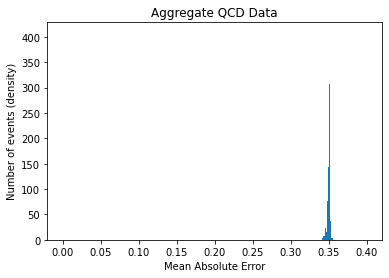

In [29]:
predict = vae.predict(x_test)
err = np.mean(np.abs(predict - x_test), axis=1)
print(np.shape(err))

bins = np.linspace(0, 0.4, 1000)
# plt.hist(err, density=True)
plt.hist(err, density=True, bins=bins)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Number of events (density)")
# Getting the name of the file we ran on
plt.title("Aggregate QCD Data")
plt.show()

(386028, 69)


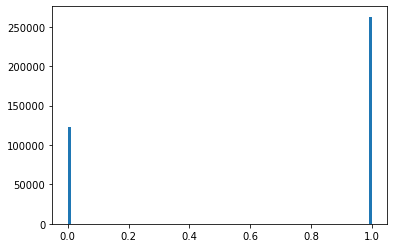

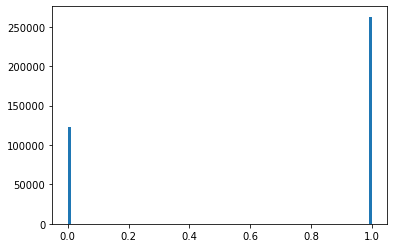

In [30]:
print(np.shape(x_test))
feat_idx = features.index("FatJet_sv_enration")
plt.hist(x_test[:, feat_idx], bins=100)
plt.show()
y_test = np.rint(x_test[:, feat_idx]).astype(int)
plt.hist(y_test, bins=100)
plt.show()

In [32]:
from sklearn.metrics import roc_curve
predict = vae.predict(x_test)
mae_y_pred = np.mean(np.abs(predict - x_test), axis=1)
sq_y_pred = np.mean(np.square(predict - x_test), axis=1)
# Experimenting with new

In [33]:
mae_fpr, mae_tpr, mae_threshold = roc_curve(y_test, mae_y_pred)
sq_fpr, sq_tpr, sq_threshold = roc_curve(y_test, sq_y_pred)
from sklearn.metrics import auc
mae_auc = auc(mae_fpr, mae_tpr)
sq_auc = auc(sq_fpr, sq_tpr)

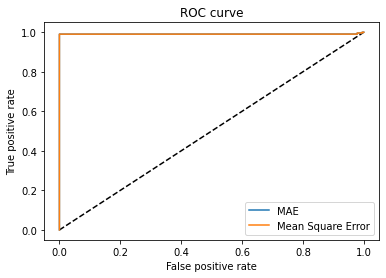

In [34]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(mae_fpr, mae_tpr, label="MAE")
plt.plot(sq_fpr, sq_tpr, label="Mean Square Error")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()